# Computational Bionics | Exercise 1: Modeling the leg


In this exercise, an ODE system for a leg composed of three components (thigh m1, shank m2, and foot m3) is modeled. The following assumptions are made:
- The body segments are treated as point masses located at their respective centers of gravity.
- All angles and directions are defined as illustrated in the sketch below.
- The hip is considered a fixed point in space

<img src="img2.png" width="500">

In this model, the forward dynamics of the leg are simulated. This means that the input consists of the moments at the hip and knee, and the resulting angles and angular velocities are to be determined by the differential equation system, as shown in the graph below:

<img src="img4.png" width="500">

### Part 1: Setting up the system

To start off, some python libraries are imported and all important input parameters are defined as numerical values:

In [2]:
import numpy as np
import sympy as smp
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import time

# input parameters
g_val = 9.81 # m/s^2
bw = 100 # kg, body weight
m1_val = 0.09 * bw + 0.73 # kg, thigh mass
m2_val = 0.055 * bw - 0.43 # kg , shank mass
m3_val = 0.001 * bw + 0.34 # kg, foot mass
l1_val = 0.5  # m, thigh length
l2_val = 0.5  # m, shank length

print("\n",
    "g =", g_val, "m/s²\n",
    "bw =", bw, "kg\n", 
    "m1 =", m1_val, "kg\n",
    "m2 =", m2_val, "kg\n",
    "m3 =", round(m3_val,4), "kg\n",
    "l1 =", l1_val, "m\n",
    "l2 =", l2_val, "m")
    


 g = 9.81 m/s²
 bw = 100 kg
 m1 = 9.73 kg
 m2 = 5.07 kg
 m3 = 0.44 kg
 l1 = 0.5 m
 l2 = 0.5 m


To determine the moments, typical moment patterns from the literature are used. The graph shown below serves as a reference. From this graph, values were *approximated* at 0%, 10%, 20%, etc. of the gait cycle and then interpolated using a CubicSpline to create a continuous function.

<img src="img3.png" width="600">

In [3]:
# Key anchor points from graph
percentages= np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
MH_approx = np.array([0.25, 0.35, 0.10, -0.15, -0.50, -0.75, -0.30, -0.15, 0.00, 0.20, 0.18]) # approximate Hip torque / kg BW
MK_approx = np.array([-0.05, 0.35, 0.30, 0.05, -0.05, -0.20, -0.10, 0.0, -0.05, -0.1, -0.05]) # approximate Knee torque / kg BW

# scale to bodyweigth
MH_scaled = [element * (-1*bw) for element in MH_approx]
MK_scaled = [element * (-1*bw) for element in MK_approx]

gait_cycle = np.linspace(0, 100, 101)  # array = 0, 1, 2, 3, ..., 100, len=101

# Create a cubic spline interpolation function
cs_hip = CubicSpline(percentages, MH_scaled, bc_type='natural')
cs_knee = CubicSpline(percentages, MK_scaled, bc_type='natural')


The simulation is to be conducted for 5 seconds, where one gait cycle (0–100%) corresponds to 1 second.

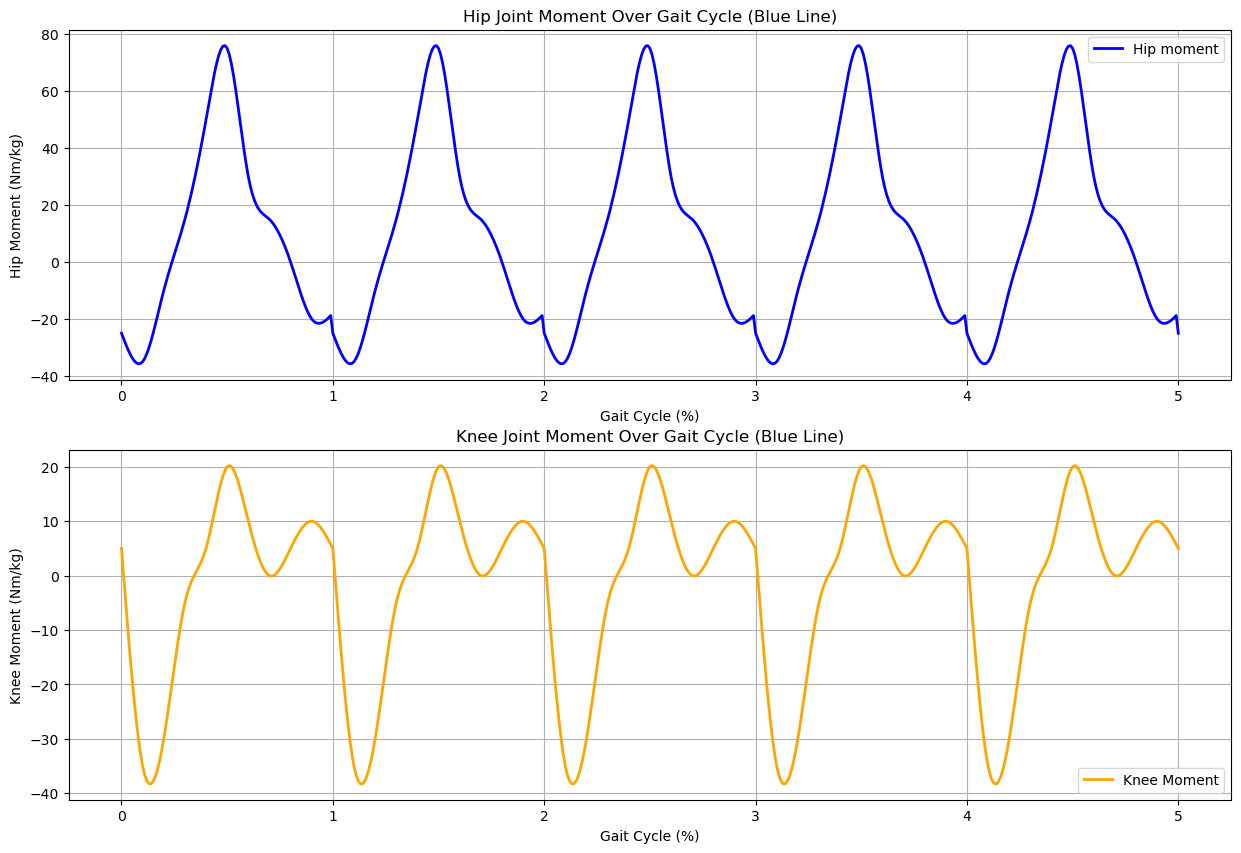

In [4]:
# simulation parameters
ts = 0 # simulation start time (s)
tf = 5 # simulation finish time (s)
duration = tf - ts # simulation duration (s)

frequency = 1  # gait-cycle per second 
T_stride = 1 / frequency  # duration of a gait-cycle (s)

num_points = 501  # Auflösung

t_eval = np.linspace(0, duration, num_points)  # simulation time points
t_normalized = (t_eval % T_stride) / T_stride * 100 # Time normalization (current progress in the gait cycle as %)

#Calculate moments for the normalized time points
MH_vals = cs_hip(t_normalized)  # hip moment
MK_vals = cs_knee(t_normalized)  # knee moment

MH_val = [round(value, 4) for value in MH_vals]
MK_val = [round(value, 4) for value in MK_vals]

# convert list to np.array
MH_val = np.array(MH_val)
MK_val = np.array(MK_val)

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot Hip joint moment on the first subplot
axs[0].plot(t_eval, MH_val, color='blue', linewidth=2, label='Hip moment')  # spline
axs[0].set_title('Hip Joint Moment Over Gait Cycle (Blue Line)')
axs[0].set_xlabel('Gait Cycle (%)')
axs[0].set_ylabel('Hip Moment (Nm/kg)')
axs[0].grid(True)
axs[0].legend()

# Plot Knee joint moment on the second subplot
axs[1].plot(t_eval, MK_val, color='orange', linewidth=2, label='Knee Moment')  # spline
axs[1].set_title('Knee Joint Moment Over Gait Cycle (Blue Line)')
axs[1].set_xlabel('Gait Cycle (%)')
axs[1].set_ylabel('Knee Moment (Nm/kg)')
axs[1].grid(True)
axs[1].legend()

### Part 2: Create the Lagrange function and calculate kinetic quantities

The system of equations is created using the Python library "Sympy". In this process, equations are initially defined, computed, and simplified **symbolically**. Subsequently, the symbolic expressions need to be converted into numerical values.

In [5]:
# Define symbolic variables
t, g = smp.symbols('t g')
m1, m2, m3 = smp.symbols('m1 m2 m3')  # Masses
l1, l2 = smp.symbols('l1 l2')  # Center of mass distances
theta1, theta2 = smp.symbols(r'\theta_1 \theta_2', cls=smp.Function)

theta1 = theta1(t)
theta2 = theta2(t)

# Angular velocities and accelerations
theta1_d = smp.diff(theta1, t)
theta2_d = smp.diff(theta2, t)
theta1_dd = smp.diff(theta1_d, t)
theta2_dd = smp.diff(theta2_d, t)

# Input torques
MH = smp.Function('MH')(t)
MK = smp.Function('MK')(t)

# Positions of masses, according to Figure 1
x1 = l1 / 2 * smp.sin(theta1)
y1 = -l1 / 2 * smp.cos(theta1)

x2 = l1 * smp.sin(theta1) + l2 / 2 * smp.sin(theta2)
y2 = -l1 * smp.cos(theta1) - l2 / 2 * smp.cos(theta2)

x3 = l1 * smp.sin(theta1) + l2 * smp.sin(theta2)
y3 = -l1 * smp.cos(theta1) - l2 * smp.cos(theta2)

# Kinetic energy
T1 = 1 / 2 * m1 * (smp.diff(x1, t)**2 + smp.diff(y1, t)**2)
T2 = 1 / 2 * m2 * (smp.diff(x2, t)**2 + smp.diff(y2, t)**2)
T3 = 1 / 2 * m3 * (smp.diff(x3, t)**2 + smp.diff(y3, t)**2)
T = T1 + T2 + T3

# Potential energy
V1 = m1 * g * y1
V2 = m2 * g * y2
V3 = m3 * g * y3
V = V1 + V2 + V3

# Lagrangian
L = T - V

# Lagrange equations
LE1 = smp.diff(smp.diff(L, theta1_d), t) - smp.diff(L, theta1) - MH 
LE2 = smp.diff(smp.diff(L, theta2_d), t) - smp.diff(L, theta2) - MK
LE1 = smp.simplify(LE1)
LE2 = smp.simplify(LE2)


The Lagrange equations now take the following form:

In [6]:
LE1

0.5*g*l1*m1*sin(\theta_1(t)) + 1.0*g*l1*m2*sin(\theta_1(t)) + 1.0*g*l1*m3*sin(\theta_1(t)) + 0.25*l1**2*m1*Derivative(\theta_1(t), (t, 2)) + 1.0*l1**2*m2*Derivative(\theta_1(t), (t, 2)) + 1.0*l1**2*m3*Derivative(\theta_1(t), (t, 2)) + 0.5*l1*l2*m2*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), t)**2 + 0.5*l1*l2*m2*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), (t, 2)) + 1.0*l1*l2*m3*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), t)**2 + 1.0*l1*l2*m3*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_2(t), (t, 2)) - 1.0*MH(t)

In [7]:
LE2

0.5*g*l2*m2*sin(\theta_2(t)) + 1.0*g*l2*m3*sin(\theta_2(t)) - 0.5*l1*l2*m2*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_1(t), t)**2 + 0.5*l1*l2*m2*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_1(t), (t, 2)) - 1.0*l1*l2*m3*sin(\theta_1(t) - \theta_2(t))*Derivative(\theta_1(t), t)**2 + 1.0*l1*l2*m3*cos(\theta_1(t) - \theta_2(t))*Derivative(\theta_1(t), (t, 2)) + 0.25*l2**2*m2*Derivative(\theta_2(t), (t, 2)) + 1.0*l2**2*m3*Derivative(\theta_2(t), (t, 2)) - 1.0*MK(t)

Solving for $\ddot{\theta}_1$ and $\ddot{\theta}_2$ is very time-consuming due to the use of symbolic equations. The time module can be used to track the computation time. In the final step, the resulting equations are converted into numerical functions using lambdify.

In [8]:
# Solve for angular accelerations (theta1_dd, theta2_dd)
st_sols = time.time()
sols = smp.solve([LE1, LE2], (theta1_dd, theta2_dd))
sols[theta1_dd] = smp.simplify(sols[theta1_dd])
sols[theta2_dd] = smp.simplify(sols[theta2_dd])
et_sols = time.time() - st_sols
print('solving successfull, computation time =', et_sols, 's')

# Simplify and convert symbolic solutions to numerical functions
theta1_dd_f = smp.lambdify((g, m1, m2, m3, l1, l2, theta1, theta2, theta1_d, theta2_d, MH, MK), sols[theta1_dd], "numpy")
theta2_dd_f = smp.lambdify((g, m1, m2, m3, l1, l2, theta1, theta2, theta1_d, theta2_d, MH, MK), sols[theta2_dd], "numpy")

solving successfull, computation time = 63.86282753944397 s


### Part 3: Definition of the ODE System

Below the ODE system is defined.

To make the model more realistic, the moments are damped depending on the velocity. For this purpose, two damping constants, $c_H$ (hip) and $c_K$ (knee), are introduced. The magnitude of these values significantly influences the behavior of the system and is therefore chosen with caution.

Additionally, the knee moment is adpated to prevent hyperextension of the knee. This adjustment was made based on several simulation runs.

In [9]:
# damping coefficient
c_H = 10.0
c_K = 5.0 

# ODE system with damping
def dSdt_damped(t, S, g, m1, m2, m3, l1, l2, MH_val, MK_val, t_eval):
    theta1, theta1_d, theta2, theta2_d = S

    # Interpolate input moments
    MH_interp = np.interp(t, t_eval, MH_val)
    MK_interp = np.interp(t, t_eval, MK_val)

    # Apply damping to the moments
    MH_damped = MH_interp - c_H * theta1_d
    MK_damped = MK_interp - c_K * theta2_d

    # Prevent overextending of the knee, when leg is moving forward
    if theta1 > 0 and theta2 > 0: 
          MK_damped += 25 * (theta2-theta1)
         
    # Calculate angular accelerations
    theta1_dd = theta1_dd_f(g, m1, m2, m3, l1, l2, theta1, theta2, theta1_d, theta2_d, MH_damped, MK_damped)
    theta2_dd = theta2_dd_f(g, m1, m2, m3, l1, l2, theta1, theta2, theta1_d, theta2_d, MH_damped, MK_damped)

    return [theta1_d, theta1_dd, theta2_d, theta2_dd]


Next, the initial conditions are set:
- $\theta_1 = 20$ (deg)
- $\dot{\theta}_1 = 0$ (deg/s)
- $\theta_2 = 18$ (deg)
- $\dot{\theta}_1 = 0$ (deg/s)

and the ODE system is solved using *solve_ivp*. 

In [9]:
# Initial conditions
y0 = [np.radians(20), 0, np.radians(18), 0]

# Solve ODE with damping
solution_damped = solve_ivp(
    dSdt_damped,
    (ts, tf),
    y0,
    t_eval=t_eval,
    args=(g_val, m1_val, m2_val, m3_val, l1_val, l2_val, MH_val, MK_val, t_eval),
    method='RK45',
    max_step= 0.001
)

# Extract results
theta1_sol = solution_damped.y[0] # theta1 
theta2_sol = solution_damped.y[2] # theta2

theta1_d_sol = solution_damped.y[1] # theta1_d
theta2_d_sol = solution_damped.y[3] # theta2_d

### Part 4: visualize the results

To visualize and understand the results of the simulationthe angles (left plot) and angular velocities (right plots) are plotted over the evaluation time

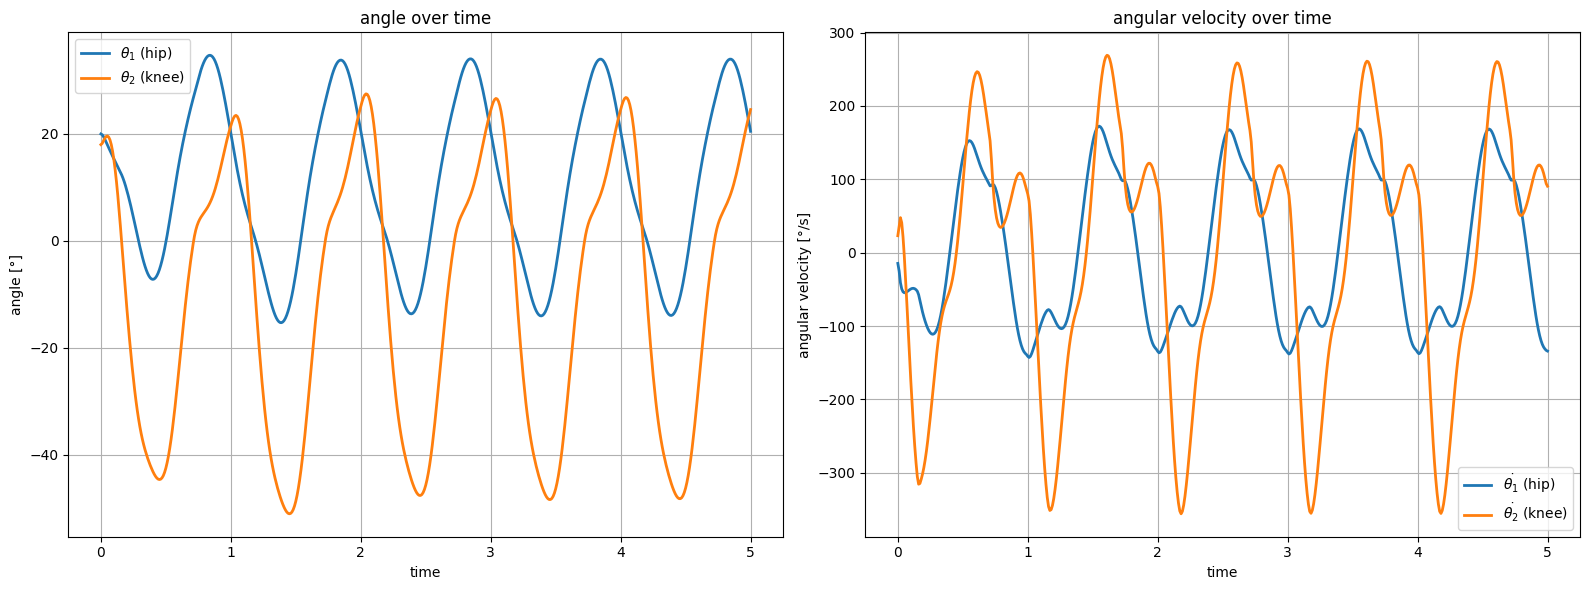

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot the angles on the first subplot
axs[0].plot(t_eval, np.degrees(theta1_sol), label=r'$\theta_1$ (hip)', linewidth=2)
axs[0].plot(t_eval, np.degrees(theta2_sol), label=r'$\theta_2$ (knee)', linewidth=2)
axs[0].set_xlabel('time')
axs[0].set_ylabel('angle [°]')
axs[0].set_title('angle over time')
axs[0].legend()
axs[0].grid()

# Plot the angular velocities on the second subplot
axs[1].plot(t_eval, np.degrees(np.gradient(theta1_sol, t_eval)), label=r'$\dot{\theta_1}$ (hip)', linewidth=2)
axs[1].plot(t_eval, np.degrees(np.gradient(theta2_sol, t_eval)), label=r'$\dot{\theta_2}$ (knee)', linewidth=2)
axs[1].set_xlabel('time')
axs[1].set_ylabel('angular velocity [°/s]')
axs[1].set_title('angular velocity over time')
axs[1].legend()
axs[1].grid()

# Show the plots
plt.tight_layout()
plt.show()

The amplitudes remain roughly the same. The system appears to be stable. To better interpret the result, an animation of the leg is created:

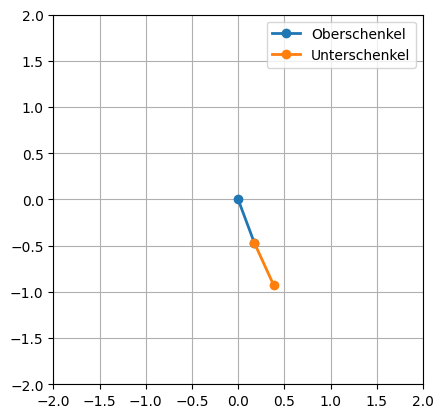

In [11]:
from matplotlib.animation import FuncAnimation, PillowWriter

# hip: fixed point in space (0, 0)
x_H, y_H = 0, 0

# knee:
x_K = l1_val * np.sin(theta1_sol)
y_K = -l1_val * np.cos(theta1_sol)

# foot:
x_S = x_K + l2_val * np.sin(theta2_sol)
y_S = y_K - l2_val * np.cos(theta2_sol)

# generate animation
fig, ax = plt.subplots()
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.grid()

# lines for thigh and shank
line_thigh, = ax.plot([], [], 'o-', label="Oberschenkel", lw=2)
line_shank, = ax.plot([], [], 'o-', label="Unterschenkel", lw=2)

# function to initialise the animation
def init():
    line_thigh.set_data([], [])
    line_shank.set_data([], [])
    return line_thigh, line_shank

# function to update the animation
def update(frame):
    # update positions
    x_data_thigh = [x_H, x_K[frame]]
    y_data_thigh = [y_H, y_K[frame]]
    x_data_shank = [x_K[frame], x_S[frame]]
    y_data_shank = [y_K[frame], y_S[frame]]

    line_thigh.set_data(x_data_thigh, y_data_thigh)
    line_shank.set_data(x_data_shank, y_data_shank)
    return line_thigh, line_shank

ani = FuncAnimation(
    fig, update, frames=len(t_eval), init_func=init, blit=True, interval=10
)

# save animation as GIF
gif_path = "Bionics-EX1_animation1.gif"  # name of the file
ani.save(gif_path, writer=PillowWriter(fps=30))

plt.legend()
plt.show()


The simulation shows the movement of the leg during the selected simulation period. The movement still appears somewhat uneven. Hyperextension of the knee could not be completely prevented. In the next step, the moments and their damping can be further adjusted to achieve a more realistic simulation.